# control analysis for fixing the gray matter (GM) template across stroke patients (prior to lesion exclusion)

In [2]:
import os, sys, csv
from nilearn import masking
import nibabel as nb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np
import pandas as pd
import multiprocessing
import itertools
import os, sys
from nipype.interfaces.fsl import MultiImageMaths
from nipype.interfaces.fsl.maths import MathsCommand
from nibabel.affines import apply_affine
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# get a common EPI mask across stroke patients  

In [3]:
fname = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(fname) as f:
    content = f.readlines()
sbj_list = [x.strip('\n') for x in content]
len(sbj_list)

28

In [4]:
rest_list = []
rest_str  = []

i = 0
for sbj in sbj_list:
    
    rest_msk = os.path.join('/data/pt_mar006/masks_Smadar_2/patients_rest_intra_masks/',
                            sbj + '_rest_intra_mask.nii.gz')
    
    rest_list.append(rest_msk)
    
    i += 1
    if i != 1:
        rest_str.append('-mul %s')

op_string_rest = " ".join((rest_str))
rest_list = []
rest_str  = []

i = 0
for sbj in sbj_list:
    
    rest_msk = os.path.join('/data/pt_mar006/masks_Smadar_2/patients_rest_intra_masks/',
                            sbj + '_rest_intra_mask.nii.gz')
    
    rest_list.append(rest_msk)
    
    i += 1
    if i != 1:
        rest_str.append('-mul %s')

op_string_rest = " ".join((rest_str))

In [5]:
maths = MultiImageMaths()
maths.inputs.in_file       = rest_list[0]
maths.inputs.op_string     = op_string_rest
maths.inputs.operand_files = rest_list[1:]
maths.inputs.out_file      = os.path.join('/data/pt_mar006/subjects_group/',
                                          'patient_mask_of_all_intra_masks.nii.gz')
maths.run()

In [6]:
rest_name = os.path.join('/data/pt_mar006/subjects_group/',
                         'patient_mask_of_all_intra_masks.nii.gz')

rest = nb.load(rest_name).get_data()

len(np.where(rest == 1)[0])

47982

In [7]:
gm_mask = os.path.join('/data/pt_mar006/subjects_group',
                        'mni3_rest_gm_mask.nii.gz')

In [8]:
maths = MultiImageMaths()
maths.inputs.in_file       = rest_name
maths.inputs.op_string     = '-mul %s'
maths.inputs.operand_files = gm_mask
maths.inputs.out_file      = '/data/pt_mar006/subjects_group/healty_gm_patient_intra.nii.gz'
maths.run()


# get the intersection of GM mask (obtained from healthy controls) and common EPI mask (obtained across stroke patients)



In [9]:
A_name = '/data/pt_mar006/figures_control/healty_gm_patient_intra.nii.gz'
A      = nb.load(A_name).get_data()
len(np.where(A == 1)[0])

30134

## New template voxel size: 30134

In [10]:
data_dir = '/data/pt_mar006/subjects_masks'

tem_fi  = os.path.join('/data/pt_mar006/subjects_group',
                        'mni3_rest_gm_mask_patients_intra.nii.gz')

for sbj in sbj_list:
    print sbj
    
    les_fi  = os.path.join(data_dir, sbj, 'lesion_mask_mni_dilated_gm.nii.gz')

    maths = MultiImageMaths()
    maths.inputs.in_file       = tem_fi
    maths.inputs.op_string     = '-sub %s'
    maths.inputs.operand_files = les_fi
    maths.inputs.out_file      = os.path.join(data_dir, sbj, 'gm_mask_no_lesion_CONTROL.nii.gz')
    maths.run()

sd02
sd05
sd08
sd10
sd13
sd14
sd16
sd17
sd21
sd25
sd26
sd28
sd31
sd32
sd33
sd35
sd36
sd38
sd39
sd40
sd42
sd43
sd44
sd45
sd46
sd48
sd49
sd52


## run main analysis for the new gm template

In [11]:
def distance_to_lesion(comp_file, concor_file, 
                       gm_file, les_file, model='spear'):

    COMP     = np.array(nb.load(comp_file).get_data())
    CONCOR   = np.array(nb.load(concor_file).get_data())
    
    gm_mask = nb.load(gm_file).get_data()
    x    = np.where(gm_mask==1)[0]
    y    = np.where(gm_mask==1)[1]
    z    = np.where(gm_mask==1)[2]

    COMPONENT   = COMP[x,y,z]
    CONCORDANCE = CONCOR[x,y,z]

    # where would be the lesion along the component
    lesion = np.array(nb.load(les_file).get_data())
    x_le   = np.where(lesion==1)[0]
    y_le   = np.where(lesion==1)[1]
    z_le   = np.where(lesion==1)[2]

    LESION = COMP[x_le, y_le, z_le]

    # define distance array
    d = np.zeros(len(COMPONENT))

    for i in range(0, len(COMPONENT)):        
            d[i] = min(abs(COMPONENT[i] - LESION))
    
    if model == 'spear':
        r, p = stats.spearmanr(d, CONCORDANCE)
    elif model == 'pear':
        r, p = stats.pearsonr(d, CONCORDANCE)
        
    return d, CONCORDANCE, COMPONENT, LESION, r

In [12]:
def get_control(concordance_file_name, data_dir, 
               comp_file_list, subject_list, 
               comp_columns, model = 'spear'): 
    
    rComps = pd.DataFrame(index=subject_list, 
                          columns=comp_columns)

    for comp_file in comp_file_list:
        
            col = 'comp_' + os.path.basename(comp_file[-8:-7])
            for subject_id in subject_list:              
                # get filenames...
                concor_file = os.path.join(data_dir, subject_id, 
                                           concordance_file_name)
                gm_file     = os.path.join(data_dir, subject_id, 
                                           'gm_mask_no_lesion_CONTROL.nii.gz')
                les_file    = os.path.join(data_dir, subject_id, 
                                           'lesion_mask_mni_gm.nii.gz')
                # run distance_to_lesion for each subject
                d, conc, comp, les, r = distance_to_lesion(comp_file,
                                                           concor_file,
                                                           gm_file,
                                                           les_file,
                                                           model=model)
                rComps.ix[subject_id][col] = r    
    return rComps

In [13]:
data_dir  = '/data/pt_mar006/subjects_masks/'

comp_file_list = ['/data/pt_mar006/components/mni3_component_1.nii.gz',
                  '/data/pt_mar006/components/mni3_component_2.nii.gz',
                  '/data/pt_mar006/components/mni3_component_3.nii.gz']

comp_columns = ['comp_1',
                'comp_2', 
                'comp_3']

list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(list_name) as f:
    subject_list = f.read().splitlines()

In [14]:
df_ccc_spear_CONTROL = get_control('conc_ccc.nii.gz',
                                   data_dir,
                                   comp_file_list,
                                   subject_list,
                                   comp_columns,
                                   model = 'spear')

In [15]:
df_ccc_spear_CONTROL

,comp_1,comp_2,comp_3
sd02,0.183074,-0.271622,0.283592
sd05,0.149967,-0.0544516,0.294476
sd08,-0.0487432,0.136769,-0.139414
sd10,0.00451973,0.0295106,0.0980512
sd13,0.0585379,-0.0156504,0.182897
sd14,0.111872,-0.125712,0.150898
sd16,-0.178932,0.144238,0.120519
sd17,0.0908902,0.376008,0.0805194
sd21,0.0720432,0.100589,0.186321
sd25,0.121373,0.108525,0.191936


In [16]:
rComps_CONTROL = df_ccc_spear_CONTROL

rComps_CONTROL = rComps_CONTROL.rename(columns={"comp_1": "Gradient 1",
                                                "comp_2": "Gradient 2",
                                                "comp_3": "Gradient 3"})

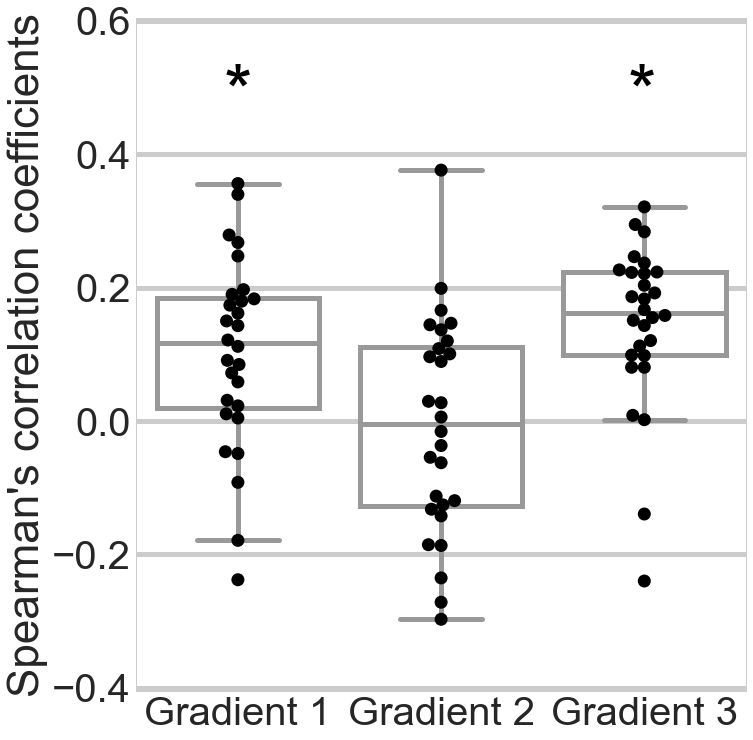

In [21]:
fig = plot_three_gradients_wilcox(rComps_CONTROL)

# #statistics...

In [22]:
#The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from 
#the same distribution. In particular, it tests whether the distribution of the differences x - y 
#is symmetric about zero. It is a non-parametric version of the paired T-test.

t, p = stats.wilcoxon(np.array(df_ccc_spear_CONTROL.comp_1, dtype=float), 
                      y=None, 
                      zero_method='zsplit', 
                      correction=True)

print "T, P : ", t, p

print "median: ", df_ccc_spear_CONTROL.comp_1.median(), 
print "mean: ", df_ccc_spear_CONTROL.comp_1.mean(), 
print "std: ", df_ccc_spear_CONTROL.comp_1.std()
print "max: ", rComps_CONTROL['Gradient 1'].max(),
print "min: ", rComps_CONTROL['Gradient 1'].min()


T, P :  63.0 0.0014900543773592823
median:  0.11662258270135176 mean:  0.10254995110897783 std:  0.14301269191006197
max:  0.3558508991287445 min:  -0.2379357755527134


In [23]:
t, p = stats.wilcoxon(np.array(df_ccc_spear_CONTROL.comp_2, dtype=float), 
                      y=None, 
                      zero_method='zsplit', 
                      correction=True)

print "T, P : ", t, p

print "median: ", df_ccc_spear_CONTROL.comp_2.median(), 
print "mean: ", df_ccc_spear_CONTROL.comp_2.mean(), 
print "std: ", df_ccc_spear_CONTROL.comp_2.std()
print "max: ", rComps_CONTROL['Gradient 2'].max(),
print "min: ", rComps_CONTROL['Gradient 2'].min()


T, P :  189.0 0.7585281090215424
median:  -0.004847836809492735 mean:  -0.0082846422036198 std:  0.1608112802662758
max:  0.376008194238075 min:  -0.29719324163350297


In [24]:
t, p = stats.wilcoxon(np.array(df_ccc_spear_CONTROL.comp_3, dtype=float), 
                      y=None, 
                      zero_method='zsplit', 
                      correction=True)

print "T, P : ", t, p

print "median: ", df_ccc_spear_CONTROL.comp_3.median(), 
print "mean: ", df_ccc_spear_CONTROL.comp_3.mean(), 
print "std: ", df_ccc_spear_CONTROL.comp_3.std()
print "max: ", rComps_CONTROL['Gradient 3'].max(),
print "min: ", rComps_CONTROL['Gradient 3'].min()

T, P :  33.0 0.00011350017471492636
median:  0.16255517794460722 mean:  0.14413649936758835 std:  0.12288452334161859
max:  0.3209256287743321 min:  -0.2398636963069745


In [18]:
def plot_three_gradients_wilcox(rComps):

    fig = plt.figure(figsize=(11.7,11.7))
    ax1 = plt.subplot(1,1,1)
   
    sns.set(context="paper", 
            font="sans-serif", 
            font_scale=5.0,
            style="whitegrid",
            rc={"grid.linewidth": 5},
            palette='Set2'
            )
    
    sns.boxplot(data=rComps, 
                linewidth = 5,
                color='white',
                ax=ax1)
    
    #plt.setp(ax1.lines, color=".3")
    sns.swarmplot(data=rComps,
                  color='k',
                  size = 13,
                  ax=ax1)
    # one-tailed Wilcoxon signed-rank test 
    from scipy import stats
    popmean=0
    cols = ['Gradient 1',
            'Gradient 2',
            'Gradient 3']
    
    x_axis = 0.335
    for col in cols:        
        r    = rComps[col].median()
        
        t, p = stats.wilcoxon(np.array(rComps[col], dtype=float), 
                              y=None, zero_method='zsplit', 
                              correction=True)
        # one-tailed
        p = p
        
        if p < 0.05 and t > 0:
            fig.text(x_axis, 0.815, "*" % (p), fontname='sans-serif', 
                     size=73, rotation=0, backgroundcolor = 'white', color = 'k',
                     ha="center", va="center")
            
        x_axis += 0.24
    ax1.set(ylim=(-0.405, 0.604))
    ax1.set(ylabel='Spearman\'s correlation coefficients')
    fig.tight_layout()    
    return fig